# Linear Elasticity

This example can be found in Section 5.2 in the following paper: [A Tutorial on Bayesian Inference to Identify Material Parameters in Solid Mechanics](https://doi.org/10.1007/s11831-018-09311-x)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "sans-serif",
        "font.sans-serif": ["Times New Roman"],
    }
)
plt.rcParams["font.family"] = "Times New Roman"

## 1. Problem statement

Given a series of experimental observations in the form of stress-strain ($\sigma$-$\epsilon$) data obtained from a uniaxial tensile test of a material specimen (as illustrated in the figure below), and acknowledging that the observations will be contaminated by a small amount of noise, infer the model parameters that describe the material response with a quantified level of uncertainty. It is essential to acknowledge and mitigate this noise to ensure the accuracy of any subsequent analyses or conclusions drawn from the data. 

![](figures/linear-elastic-experimental-observations.png)

<!-- #### General problem statement

Given a set of observed realisations of a random variable $X$,

$$S = \{x_1, x_2, ..., x_N\}, \quad x_j \in \mathbb{R}^n$$
 
we aim to infer the underlying probability distributions that generate the data set $S$. -->

## 2. Inverse problems

The problem statement is an example of an **inverse problem**. The goal of an inverse problem is to estimate an unknown parameter that is not directly observable by using measured data and a mathematical model linking the observed and the unknown.

A mathematical model is selected or designed to describe the relationship between the observed data and the unknown parameter, and the model parameters are adjusted to minimise the disparity between the predicted values and actual observations. Iterative optimisation techniques are typically employed to find the best-fitting parameters by minimising a cost function that quantifies the mismatch between the observed data and the predictions of the mathematical model. Through this process of model fitting, predictions or estimations about the unknown parameter can be derived.

Conventional methods have a number of limitations:

1. **Overfitting:** Conventional methods may overfit the data, particularly when dealing with high-dimensional datasets or when the model is overly complex relative to the available data. Overfitting can result in poor generalisation performance and unreliable estimates of the unknown parameter.

2. **Uncertainty quantification:** Conventional methods typically do not provide a straightforward means to quantify uncertainty in the estimated parameters. Instead, they offer **point estimates** that do not capture the inherent uncertainty in the data or the model assumptions.

3. **Multiple solutions:** Inverse problems may have multiple solutions, especially when considering real-world noisy data. This multiplicity of solutions complicates the process of identifying the true underlying parameter, as different sets of parameters may equally well explain the observed data.

4. **Ill-posedness:** In many cases, inverse problems are ill-posed, meaning that small changes in the observed data can lead to large changes in the estimated parameters. This sensitivity to data perturbations makes it challenging to obtain stable and reliable solutions.

### 2.1 Optimisation (gradient descent)

Iterative optimisation techniques are typically employed to solve inverse problems. They aim to determine the best-fitting parameters by minimising a cost function that quantifies the mismatch between the observed data and the predictions of the mathematical model.  One common technique is gradient descent, which iteratively adjusts the parameters in the direction that reduces the cost function most rapidly.

Gradient descent and its variants, such as stochastic gradient descent (SGD) and adaptive moment estimation (Adam), are widely used due to their efficiency and scalability. These methods leverage the gradient of the cost function with respect to the parameters to make informed updates, gradually converging to a local or global minimum of the cost function. As stated above, these techniques only offer point estimates and fail to capture uncertainty.

The below `GradientDescent` class implements a gradient descent optimiser with momentum to minimise the mean squared error between observed data and model predictions, using finite differences to compute the gradient.

In [2]:
class GradientDescent:

    def __init__(self, model, observed, initial_candidate):
        self.model = model
        self.observed = observed
        self.candidate = np.atleast_1d(initial_candidate)
        self.velocity = np.zeros_like(self.candidate)

    def optimise(self, step_size, momentum=0.99, n_steps=100):
        """
        Optimise the cost function using gradient descent with momentum
        """
        step_size = np.atleast_1d(step_size)
        cost_hist, candidate_hist = [], []

        for _ in range(n_steps):
            self.velocity = (momentum * self.velocity) - (step_size * self._compute_gradient())
            self.candidate += self.velocity
            candidate_hist.append(np.copy(self.candidate))
            cost_hist.append(self._cost_function(self.candidate))

        return np.array(candidate_hist), np.array(cost_hist)

    def _compute_gradient(self, h=1e-5):
        """
        Employ the finite difference method to compute the gradient of the
        cost function with respect to the model parameters.
        """
        x = self.candidate
        gradient = np.zeros_like(x)

        for i in range(len(x)):
            x_forward, x_backward = np.copy(x), np.copy(x)
            x_forward[i] += h
            x_backward[i] -= h
            gradient[i] = (
                self._cost_function(x_forward) - self._cost_function(x_backward)
            ) / (2 * h)

        return gradient

    def _cost_function(self, candidate):
        """
        Compute the mean squared error between the observed data
        and the model predictions
        """
        return np.mean((self.observed - self.model(candidate)) ** 2)

## 3. Bayesian inference

A Bayesian framework offers significant advantages for addressing inverse problems. Bayesian inference is the process of updating our beliefs about the probability of an event based on prior knowledge and observed data using Bayes' theorem. In the context of the presented problem, we update our beliefs about the probability of the parameter values in our model based on prior knowledge and experimental observations. Bayes' theorem is an extremely powerful concept, particularly in situations where uncertainty exists and where prior knowledge or beliefs can be incorporated into the analysis.

### 3.1 Bayes' Theorem

**Bayes' theorem** is used to determine the probability of a hypothesis given observed evidence (the posterior probability). In this example, we can think of the hypothesis and evidence as follows:

- **Hypothesis:** we hypothesise a model and values for the model parameters, and then we assess how well the model parameters explain the observations
- **Evidence:** the evidence is in the form of experimental observations (stress-strain data from a uniaxial tensile test)

The posterior probability is a function of the prior probability (prior knowledge) and a 'likelihood function' derived from a statistical model for the observed data. Bayesian inference computes the posterior probability according to Bayes' theorem:

$$
\text{Bayes' Theorem:} \quad \pi(\textbf{x}|\textbf{y}) = \frac{\pi(\textbf{x}) \cdot \pi(\textbf{y}|\textbf{x})}{\pi(\textbf{y})}
$$

where:
- $\pi(\textbf{x}|\textbf{y})$ is the **posterior probability**
- $\pi(\textbf{x})$ is the **prior probability**
- $\pi(\textbf{y}|\textbf{x})$ is the **likelihood**
- $\pi(\textbf{y})$ is the **marginal likelihood** or **evidence**
- $\textbf{x}$ denotes a vector with $n_p$ model parameters
- $\textbf{y}$ denotes a vector with $n_m$ observations

A brief description of the likelihood, prior and posterior is provided below:

- **Likelihood $\pi(\textbf{y}|\textbf{x})$**: This represents the probability of the observed data given the model parameters. It quantifies how likely the observed evidence is under different parameter values.
- **Prior $\pi(\textbf{x})$**: This represents our initial beliefs about the distribution of the model parameters before observing any data. It incorporates any prior knowledge or assumptions about the parameters.
- **Posterior $\pi(\textbf{x}|\textbf{y})$**: This is the updated probability distribution of the model parameters after taking the observed data into account. It combines the prior and the likelihood to give a comprehensive understanding of the parameter values in light of the evidence.

In summary, Bayes' theorem allows us to update our beliefs about model parameters by integrating prior knowledge with experimental observations, providing a robust framework for handling uncertainty and making informed inferences.

### 3.2 Advantages

There are multiple reasons why a Bayesian framework is better suited for solving inverse problems:

1. **Incorporating prior knowledge:** Bayesian inference enables us to incorporate prior knowledge or beliefs about the unknown parameter into the estimation process. This proves particularly useful when dealing with limited data, as it helps regularise the estimation and reduces the risk of overfitting.
2. **Flexibility in modelling:** Unlike traditional methods, which often rely on specific assumptions about the data-generating process (e.g. linearity in linear regression), Bayesian inference provides a flexible framework for modelling complex relationships and incorporating various sources of uncertainty.
3. **Uncertainty quantification:** Bayesian inference naturally provides a means to quantify uncertainty in the estimated parameters through the posterior distribution. This allows for more informed decision-making by accounting for the inherent uncertainty in the data and the model.

Overall, the Bayesian framework offers a principled approach to solving inverse problems by integrating prior knowledge, capturing uncertainty, and providing more robust and interpretable estimates compared to traditional methods.


### 3.3 Model

Upon examining the above experimental observations, an expert will likely determine that the material response is best characterised by a linear elastic model. The behaviour of a linear elastic material is described by a single parameter, Young's modulus $E$, and the stress-strain relationship in a linear elastic material during uniaxial tension can be expressed as:

$$\sigma(\epsilon, \textbf{x}) = E\epsilon$$

where $\sigma$ represents stress, $\epsilon$ represents strain, $\textbf{x}$ denotes the model parameter vector (in this case, $\textbf{x} = E$), and $E$ denotes Young's modulus.

<!-- ![](figures/linear-elastic-material-model.png) -->

Below is a function (`compute_stress`) that, given $E$, will compute the stress for any value of strain. Subsequently, the stress-strain response for a linear elastic material is plotted below.

In [3]:
def compute_stress(E, strain):
    """
    Linear elastic material
    """
    return E * strain

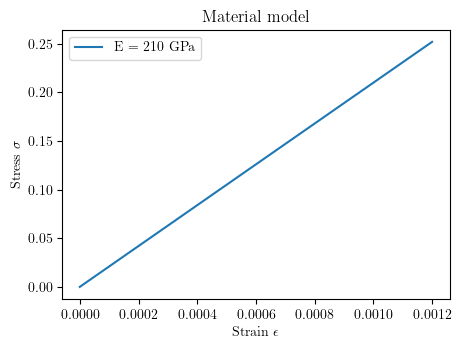

In [4]:
E = 210
strain = np.linspace(0, 1.2e-3, 100)
stress = compute_stress(E, strain)

plt.figure(figsize=(5, 3.5))
plt.plot(strain, stress, label=f"E = {E} GPa")
plt.title("Material model")
plt.xlabel("Strain $\epsilon$")
plt.ylabel("Stress $\sigma$")
plt.legend()
plt.savefig("figures/linear-elastic-material-model.png", dpi=300)

The below `BaseModel` class provides a template for constructing diverse models, mandating that subclasses implement a `__call__` method that defines the models behaviour. By inheriting from `BaseModel`, the `LinearElastic` class follows a consistent structure that facilitates easy integration into the inference and optimisation framework.

In [5]:
class BaseModel:
    """
    Base class for models used in Bayesian inference.

    Subclasses must implement the __call__ method.
    """

    def __call__(self, *args, **kwargs):
        """
        Define the behaviour of the model.

        Parameters
        ----------
        *args : tuple
            Positional arguments

        **kwargs : dict
            Keyword arguments

        Returns
        -------
        Any
            The output of the model.
        """
        raise NotImplementedError("Subclasses must implement __call__ method.")


class LinearElastic(BaseModel):
    """
    Linear elastic material model

    Attributes:
    -----------
    x_observed : float
        The observed value of the independent variable
    """

    def __init__(self, x_observed):
        """
        Parameters
        ----------
        x_observed : float
            The observed value of the independent variable
        """
        self.x_observed = x_observed

    def __call__(self, parameters):
        """
        Compute stress based on the provided parameters

        Parameters
        ----------
        parameters : tuple or list
            Model parameters. For a linear elastic model, it should contain
            only one parameter representing the Young's Modulus.

        Returns
        -------
        stress : float
            Computed stress
        """
        return parameters * self.x_observed

### 3.4 Likelihood $\pi(\textbf{y}|\textbf{x})$

The likelihood function represents the probability that the observed data $\textbf{y}$ was generated by the model parameters $\textbf{x}$. Thus, when evaluated on a given sample of the model parameters $\textbf{x}$, the likelihood function indicates which parameter values are more likely than others, in the sense that they would have made the observed data $\textbf{y}$ more probable. A low value of likelihood would indicate that either the model is wrong, the model parameters are wrong, or the observed data is rare. To construct the likelihood function we need to define a model that represents the data-generating process.

#### Statistical generating model 

We define a statistical model that represents the data-generating process (i.e. a model of our experimental data).

$$\textbf{y} = \textbf{f}(\textbf{x}) + \mathbf{\Omega}$$

where $\textbf{y}$ denotes a vector with $n_m$ experimental observations, $\textbf{x}$ denotes a vector with $n_p$ unknown model parameters, and $\mathbf{\Omega}$ is the noise in the experimental observations. We assume that the noise distribution is known (including its parameters). $\textbf{f}(\textbf{x})$ denotes the model and is a function of the unknown model parameters $\textbf{x}$. For this case the only unknown parameter is the material stiffness $E$. The likelihood function is formulated as follows:

$$\pi(\textbf{y}|\textbf{x}) = \pi_{noise}(\textbf{y} - \textbf{f}(\textbf{x}))$$

The only unknown material parameter in the linear elastic model is the Young's modulus ($E$) and based on the above, the additive noise model for a single stress measurement can be written as follows:

$$y = E\epsilon + \Omega$$

where $y$ denotes the measured stress and $\Omega$ denotes the random variable representing the noise in the stress measurement. We consider the noise distribution to be normal (Gaussian) and hence, the likelihood function for a single observation can be expressed as:

$$\pi(y|E) = \pi_{noise}(y - E\epsilon) = \frac{1}{s_{noise}\sqrt{2\pi}}exp\left(-\frac{1}{2}{\frac{(y - E\epsilon)^2}{s^2_{noise}}}\right)$$

The likelihood for all observations can be expressed as:

$$\pi(\textbf{y}|E) = \frac{1}{s_{noise}\sqrt{2\pi}}exp\left(-\frac{1}{2}{\frac{\sum_{i=1}^{n_m}(y - E\epsilon)^2}{s^2_{noise}}}\right)$$

In [6]:
class Likelihood:

    def __init__(self, y, sigma, model):
        """
        y : ndarray
            Observed data
        """
        self.y = y
        self.sigma = sigma
        self.model = model

    def evaluate(self, x):
        """
        x : float or array-like
            The value(s) of the model parameters.
        """
        residual = self._compute_residual(x)
        return (
            1
            / (self.sigma * np.sqrt(2 * np.pi))
            * np.exp(-0.5 * (residual / self.sigma**2))
        )

    def _compute_residual(self, x):
        return np.sum((self.y - self.model(x)) ** 2)

### 3.5 Prior $\pi(\textbf{x})$

The prior encapsulates the initial belief regarding the value of a parameter before considering any evidence. The prior can be established through consulting experts or examining existing literature, for example, to determine a typical value for material stiffness. In our case, the sole unknown parameter is the material stiffness $E$, and we adopt a prior represented by a modified normal distribution:

$$\pi(E) \propto exp\left(-\frac{(E - \overline{E})^2}{2s^2_E}\right) \quad \text{if}\; E \geqslant 0$$

This distribution is chosen to reflect the constraint that material stiffness cannot be negative or zero. The parameter $\overline{E}$ denotes the mean stiffness value, while $s_E$ represents the standard deviation. Utilising this prior distribution enables us to incorporate our understanding of material properties into the analysis, providing a foundation for making informed inferences about $E$. This concept is very powerful when we only have a small data set.

In [7]:
class Prior:

    def __init__(self, mu=0, sigma=1):
        """
        Initialise the normal prior distribution.

        Parameters
        ----------
        mu : float, optional
            Mean of the normal distribution. Default is 0.

        sigma : float, optional
            Standard deviation of the normal distribution. Default is 1.
        """
        self.mu = mu
        self.sigma = sigma

    def evaluate(self, x):
        """
        Evaluate the prior function at the given value(s) of x.

        Parameters
        ----------
        x : float or array-like
            The value(s) at which to evaluate the prior function.

        Returns
        -------
        float or array-like
            The prior probability density at the given value(s).
        """
        return scipy.stats.norm.pdf(x, loc=self.mu, scale=self.sigma)

    def plot(self, x_values):
        """
        Plot the prior function over a range of x values.

        Parameters
        ----------
        x_values : array-like
            The range of x values for plotting.
        """
        plt.plot(x_values, self.evaluate(x_values))
        plt.xlabel("x")
        plt.ylabel("Probability Density")
        plt.title("Prior")
        plt.yticks([])

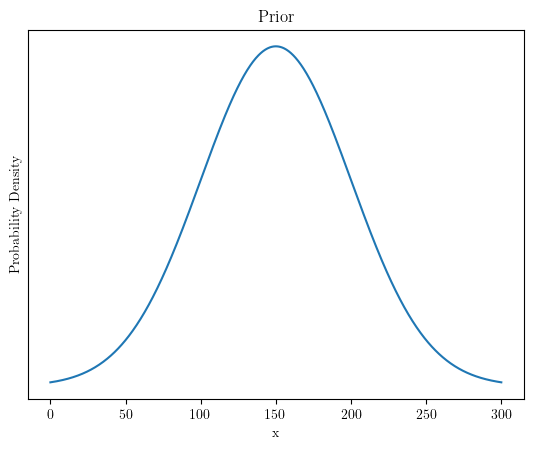

In [8]:
Prior(150, 50).plot(np.linspace(0, 300, 1000))

### 3.6 Posterior $\pi(E|y)$

The PDF of the unknown parameters $\textbf{x}$, given the observations $\textbf{y}$

The posterior distribution for a single stress measurement reads:

$$\pi(\textbf{x}|\textbf{y}) \propto \pi(\textbf{x})\pi(\textbf{y}|\textbf{x})$$

$$\pi(E|y) \propto exp\left(-\left[\frac{(E - \overline{E})^2}{2s^2_E} + \frac{(y-E\epsilon)^2} {2s^2_{noise}}\right]\right) \quad \text{if}\; E \geqslant 0$$

Since the data $y$ is already measured, the denominator in Bayes' Theorem $\pi(y)$ is a positive constant number $C$. This constant number can be regarded as a normalisation factor that ensures that the integral of the posterior $\pi(E|y)$ over $E$ equals 1:

$$\pi(E|y) = \frac{1}{C}\pi(E)\pi(y|E)$$

In [9]:
class Posterior:

    def __init__(self, prior, likelihood):
        self.prior = prior
        self.likelihood = likelihood

    def evaluate(self, x):
        """
        Compute the posterior distribution for given model parameters and observed data.

        Parameters
        ----------
        x : float or array-like
            The value(s) of the model parameters.

        Returns
        -------
        float or array-like
            The posterior probability distribution for the given model parameters.
        """
        return self.prior.evaluate(x) * self.likelihood.evaluate(x)

## 4. Generating synthetic data

In order to introduce the Bayesian approach in the most intuitive manner, the experimental observations are generated numerically so that they deviate from the *true* constitutive model using a known noise model. This allows for a one-to-one comparison between the *true* parameter values and the inferred parameter distributions.

### *True* material parameters

The *true* value of $E$ that we are attempting to identify (infer) from the experimental observations is:

$$E = 210 \; \textrm{GPa}$$

The noise $\Omega$ in the stress measurements has a normal distribution with a zero mean and a standard deviation of $s_{noise}$. Note that in this case, only the stress measurement is contaminated by noise. 

$$\Omega = \mathcal{N}(\mu, \sigma^2) = \mathcal{N}(0, 0.01^2)$$

The *true* stress-strain response and the noisy experimental observations are illustrated in the following figure.

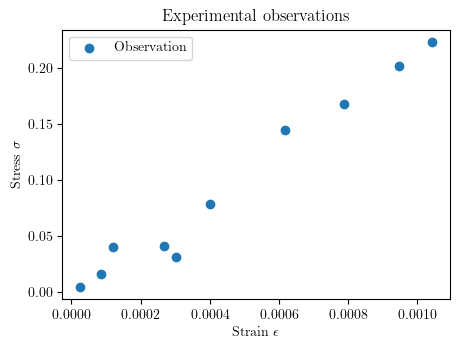

In [10]:
sigma = 0.01  # standard deviation of the noise
n_observations = 10
x = np.linspace(0, 1.2e-3, 100)
strain_observed = np.random.choice(x, n_observations)
stress_observed = compute_stress(E, strain_observed) + np.random.normal(
    scale=sigma, size=strain_observed.shape[0]
)  # noisy data

plt.figure(figsize=(5, 3.5))
plt.scatter(strain_observed, stress_observed, label="Observation")
plt.title("Experimental observations")
plt.xlabel("Strain $\epsilon$")
plt.ylabel("Stress $\sigma$")
plt.legend()
# plt.savefig("figures/linear-elastic-experimental-observations.png", dpi=300)

## 5. Compute the Posterior Distribution

Bayesian inference allows us to update our beliefs about parameters based on observed data. This updating process results in the posterior distribution, which encapsulates our updated knowledge about the parameters after considering the data. Several methods can be employed to compute the posterior distribution:

#### Analytical Solution:

In the presented linear-elastic model, the posterior can be determined analytically because the noise model is additive, and both the noise distribution and the prior distribution are (modified) normal distributions. When the prior and likelihood functions have conjugate distributions, a closed-form solution is possible. Examples include the normal-normal and beta-binomial models. However, the posterior can only be determined analytically in a limited number of simple cases, and for real-world problems, numerical methods are typically employed.

#### Grid Search:

In cases where analytical solutions are not feasible due to complex or non-standard distributions, grid search provides a practical numerical approach. In grid search, the parameter space is discretised into a grid, and the posterior probability is computed for each grid point. This method involves evaluating the prior and likelihood functions at each grid point and then normalising to obtain the posterior probabilities. While grid search is straightforward to implement, it may not be feasible when the model is computationally expensive, and will become extremely computationally intensive for high-dimensional parameter spaces.

#### Markov Chain Monte Carlo (MCMC):

MCMC methods offer a powerful and versatile approach to estimate the posterior distribution, particularly in high-dimensional and complex models where analytical solutions or grid search are impractical. MCMC algorithms, such as Metropolis-Hastings and Gibbs sampling, generate a Markov chain that asymptotically converges to samples from the target posterior distribution. These methods iteratively propose candidate parameter values, accepting or rejecting them based on a defined acceptance criterion that preserves the desired distribution. MCMC provides flexibility in handling complex models and can efficiently explore the parameter space, even in cases of high dimensionality or non-standard distributions. A simple Metropolis-Hastings sampler is implemented in Section 6.

#### Summary

Each of these methods has its strengths and limitations, and the choice depends on factors such as the complexity of the model, computational resources available, and the desired accuracy of the posterior estimation. Additionally, combining multiple approaches or employing advanced MCMC techniques, such as Hamiltonian Monte Carlo, can further enhance the accuracy and efficiency of Bayesian inference in various scenarios. We will begin by employing a simple grid search, as implemented in `grid_search()`.

In [11]:
def grid_search(posterior, parameter_candidates):
    """
    Search every possible candidate
    """
    return [posterior.evaluate(candidate) for candidate in parameter_candidates]

### 5.1 Compute the posterior using a subset of observations

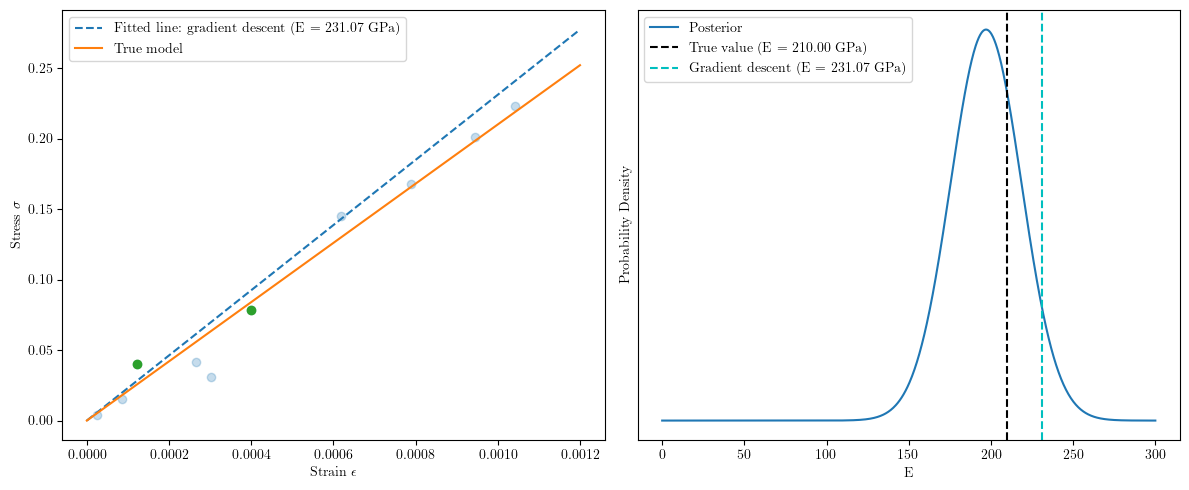

In [12]:
subset = np.random.randint(len(strain_observed), size=2)

model = LinearElastic(strain_observed[subset])
prior = Prior(150, 50)
likelihood = Likelihood(stress_observed[subset], 0.01, model)
posterior = Posterior(prior, likelihood)

pdf = grid_search(
    posterior, np.linspace(0, 300, 1000)
)  # posterior.evaluate(np.linspace(0, 300, 1000))
optimiser = GradientDescent(model, stress_observed[subset], 240.00)
candidate_hist, cost_hist = optimiser.optimise(step_size=20.00, n_steps=1000)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(
    strain,
    candidate_hist[-1] * strain,
    "--",
    color="C0",
    label="Fitted line: gradient descent (E = {:.2f} GPa)".format(candidate_hist[-1].item()),
)
ax1.plot(strain, E * strain, color="C1", label="True model")
ax1.scatter(strain_observed, stress_observed, alpha=0.25)
ax1.scatter(strain_observed[subset], stress_observed[subset], color="C2")
ax1.set_xlabel("Strain $\epsilon$")
ax1.set_ylabel("Stress $\sigma$")
ax1.legend()

# ax2.plot(np.linspace(0, 300, 1000), prior.evaluate(np.linspace(0, 300, 1000)), label="Prior")
ax2.plot(np.linspace(0, 300, 1000), pdf, label="Posterior")
ax2.axvline(
    x=210, label="True value (E = {:.2f} GPa)".format(210), linestyle="--", color="k"
)
ax2.axvline(
    x=candidate_hist[-1].item(),
    label="Gradient descent (E = {:.2f} GPa)".format(candidate_hist[-1].item()),
    linestyle="--",
    color="c",
)
ax2.set_xlabel("E")
ax2.set_ylabel("Probability Density")
ax2.set_yticks([])
ax2.legend()

plt.tight_layout()

### 5.1.1 Plot the cost function

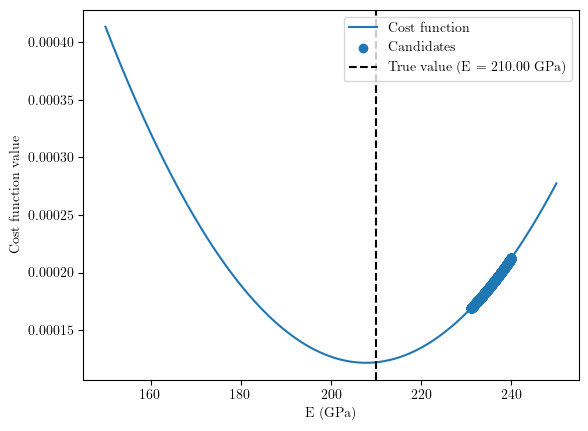

In [13]:
E_range = np.linspace(150, 250, 1000)

fig, ax1 = plt.subplots()
ax1.plot(E_range, [optimiser._cost_function(E) for E in E_range], label="Cost function")
ax1.scatter(candidate_hist, [optimiser._cost_function(candidate) for candidate in candidate_hist], label="Candidates")
ax1.axvline(x=210, label="True value (E = {:.2f} GPa)".format(210), linestyle="--", color="k")

ax1.set_xlabel('E (GPa)')
ax1.set_ylabel('Cost function value')
ax1.legend();

### 5.2 Compute the posterior using all observations

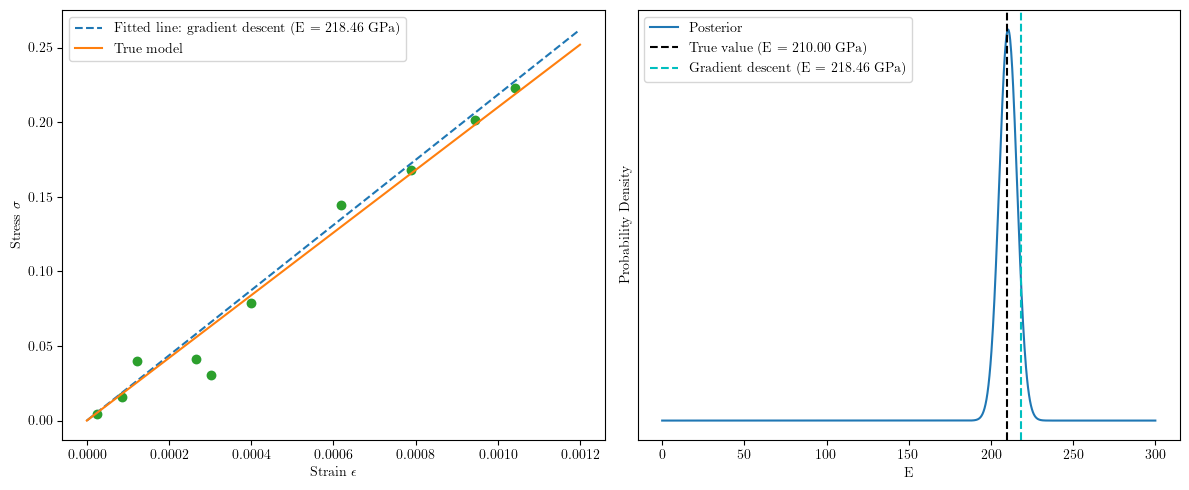

In [14]:
model = LinearElastic(strain_observed)
prior = Prior(150, 50)
likelihood = Likelihood(stress_observed, 0.01, model)
posterior = Posterior(prior, likelihood)

pdf = grid_search(
    posterior, np.linspace(0, 300, 1000)
)  # posterior.evaluate(np.linspace(0, 300, 1000))
optimiser = GradientDescent(model, stress_observed, 240.00)
candidate_hist, cost_hist = optimiser.optimise(step_size=20.00, n_steps=1000)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(
    strain,
    candidate_hist[-1] * strain,
    "--",
    color="C0",
    label="Fitted line: gradient descent (E = {:.2f} GPa)".format(candidate_hist[-1].item()),
)
ax1.plot(strain, E * strain, color="C1", label="True model")
ax1.scatter(strain_observed, stress_observed, alpha=0.25)
ax1.scatter(strain_observed, stress_observed, color="C2")
ax1.set_xlabel("Strain $\epsilon$")
ax1.set_ylabel("Stress $\sigma$")
ax1.legend()

# ax2.plot(np.linspace(0, 300, 1000), prior.evaluate(np.linspace(0, 300, 1000)), label="Prior")
ax2.plot(np.linspace(0, 300, 1000), pdf, label="Posterior")
ax2.axvline(
    x=210, label="True value (E = {:.2f} GPa)".format(210), linestyle="--", color="k"
)
ax2.axvline(
    x=candidate_hist[-1].item(),
    label="Gradient descent (E = {:.2f} GPa)".format(candidate_hist[-1].item()),
    linestyle="--",
    color="c",
)
ax2.set_xlabel("E")
ax2.set_ylabel("Probability Density")
ax2.set_yticks([])
ax2.legend()

plt.tight_layout()

### 5.2.1 Plot the cost function

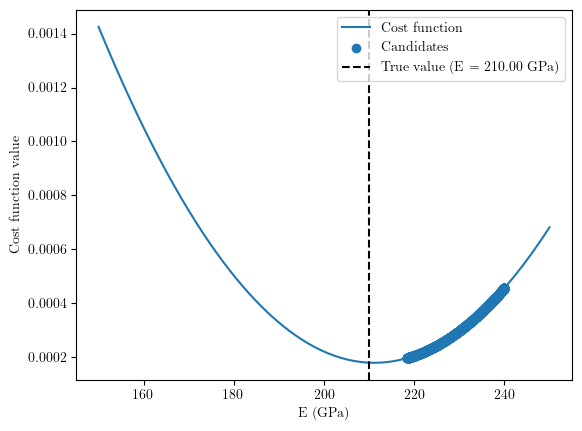

In [15]:
fig, ax1 = plt.subplots()
ax1.plot(E_range, [optimiser._cost_function(E) for E in E_range], label="Cost function")
ax1.scatter(candidate_hist, [optimiser._cost_function(candidate) for candidate in candidate_hist], label="Candidates")
ax1.axvline(x=210, label="True value (E = {:.2f} GPa)".format(210), linestyle="--", color="k")

ax1.set_xlabel('E (GPa)')
ax1.set_ylabel('Cost function value')
ax1.legend();

### 5.3 Why are density values omitted?

When plotting the posterior density in Bayesian statistics, it is customary not to include density values on the y-axis of the plot. Instead, the y-axis typically represents the relative probability or density of different parameter values given the observed data.

There are multiple reasons for omitting density values:

1. **Relative comparison**: The principal objective of a posterior density plot is to visualise the distribution's shape and understand the relative likelihoods of different parameter values. Including density values on the y-axis would not significantly enhance interpretation, as the focus lies on the distribution's shape and how it varies across parameter values.

2. **Normalisation**: Posterior densities are often scaled so that the area under the curve equals 1. Including density values on the y-axis would necessitate selecting a scale that may not be immediately intuitive and could detract from the primary purpose of the plot.

3. **Interpretability**: Posterior densities are frequently interpreted in a relative sense rather than in terms of absolute density values. For instance, a higher peak in the posterior density indicates that a particular parameter value is more probable given the observed data, but the actual density value at that point may lack direct interpretation.

4. **Focus on shape**: Excluding density values facilitates focusing on the distribution's shape and visually comparing different parameter values. This aids in comprehending the uncertainty associated with parameter estimation and identifying regions of high probability.

In summary, the absence of density values on the y-axis of posterior density plots helps maintain clarity and focus on the relative likelihoods of different parameter values, which is typically the primary objective when visualising posterior distributions in Bayesian analysis.

## 6. Metropolis-Hastings

When the search space becomes larger, or the model is expensive to evaluate, it can become infeasible to do an exhaustive search and we must turn to randomised searches. Markov Chain Monte Carlo (MCMC) methods are the most common approach in such scenarios. The aim of MCMC is to randomly walk through the parameter space, while the fraction of time spent at each state $\theta_i$ is $\propto$ the unormalised posterior. While various libraries exist for posterior exploration, we will implement a [Metropolis-Hastings](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) sampler to aid comprehension. Please note that the code for the sampler below is originally sourced from this [blog](https://colindcarroll.com/2018/11/24/animated-mcmc-with-matplotlib/) by Colin Carroll.

In the next [example](02-linear-elasticity-perfect.ipynb) we will write a `Sampler` class 

In [16]:
def mh_sampler(posterior, steps=3000, step_size=5, init=0):
    """
    Metropolis-Hastings sampler with a normal proposal
    """
    point = init
    samples = []
    pdf = []
    for _ in range(int(steps)):
        proposal = np.random.normal(point, step_size)
        if np.random.rand() < posterior.evaluate(proposal) / posterior.evaluate(point):
            point = proposal
        samples.append(point)
        pdf.append(posterior.evaluate(point))
    return np.array(samples), np.array(pdf)

### 6.1 Sample and plot the chain

In [ ]:
samples, pdf = mh_sampler(
    posterior,
    steps=1e5,
    step_size=2.5,
    init=150,
)

plt.plot(samples)
plt.xlabel('Sample number')
plt.ylabel('E')
plt.axhline(E, ls="--", color="dimgray")

### 6.2 Statistical summaries

Once the posterior has been sampled, it needs to be analysed to determine the statistical summaries.

During the initial sampling phase (commonly referred to as the burn-in phase), the chain is still adjusting and exploring the parameter space, potentially starting from an arbitrary initial state or distribution. The initial samples may not accurately represent the true posterior distribution because the chain has not yet stabilised. Therefore, these initial samples are discarded (burned) and not used for analysis purposes.

After discarding the burn-in samples, the remaining samples can be used to estimate various statistical summaries. One key summary is the **Maximum A Posteriori (MAP) estimate**, which is the mode of the posterior distribution and represents the most likely value given the data. Additionally, **credible intervals** can be computed to provide a range of values within which the true parameter value is likely to lie with a certain probability.

In [ ]:
def estimate_map_point(x, pdf, burn=1000):
    """
    Calculate the maximum a posteriori probability (MAP) point - 
    the point at which the posterior distribution is (globally) maximum
    """
    x_burned = x[burn:]
    pdf_burned = pdf[burn:]
    return x_burned[np.argmax(pdf_burned)]

In [ ]:
def compute_credible_interval(x, interval=0.95, burn=1000):
    """
    Compure the the 95% credible region - 
    the region that contains 95% of the posterior
    """
    x_burned = x[burn:]
    x_sorted = np.sort(x_burned)
    lower_bound = x_sorted[int((1 - interval) / 2 * len(x_sorted))]
    upper_bound = x_sorted[int((1 + interval) / 2 * len(x_sorted))]
    return (lower_bound, upper_bound)

In [ ]:
map_point = estimate_map_point(samples, pdf, burn=0)
print('The estimated MAP point is {:.2f} GPa'.format(map_point))

credible_interval = compute_credible_interval(samples)
print('The 95% credible interval is [{:.2f}, {:.2f}] GPa'.format(credible_interval[0], credible_interval[1]))

### 6.3 Plot the posterior

The plot below shows the posterior probability density on the left and a histogram of the number of samples on the right.

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.scatter(samples[1000:], pdf[1000:])
ax1.axvline(E, ls="--", color="k", label='True value')
ax1.axvline(map_point, ls="--", color="blue", label='MAP')
ax1.axvspan(credible_interval[0], credible_interval[1], alpha=0.1, facecolor='red', edgecolor='none', label='95\% credible interval')

ax1.set_xlabel('E')
ax1.set_ylabel('Probability Density')
ax1.set_yticks([])

ax2.hist(samples[1000:], bins=100, alpha=0.75, color="skyblue")
ax2.axvline(E, ls="--", color="k", label='True value')
ax2.axvline(map_point, ls="--", color="blue", label='MAP')
ax2.axvspan(credible_interval[0], credible_interval[1], alpha=0.1, facecolor='red', edgecolor='none', label='95\% credible interval')

ax2.set_xlabel('E')
ax2.set_ylabel('Number of samples')

ax1.legend(loc='upper left')
plt.tight_layout()

### 6.4 Posterior Predictive Distribution (95% prediction interval)

In [ ]:
predictions = np.array([compute_stress(sample, strain) for sample in samples])

posterior_predictive_mean = np.mean(predictions, axis=0)
posterior_predictive_std = np.std(predictions, axis=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(strain_observed, stress_observed, color="blue", label="Observation")
ax1.plot(strain, stress, "k--", label="True")
ax1.plot(
    strain, posterior_predictive_mean, color="red", label="Posterior Predictive Mean"
)
ax1.fill_between(
    strain,
    posterior_predictive_mean - 2 * posterior_predictive_std,
    posterior_predictive_mean + 2 * posterior_predictive_std,
    facecolor='red',
    edgecolor='none',
    alpha=0.2,
    label='Posterior Predictive Distribution',
)
ax1.set_xlabel('Strain $\epsilon$')
ax1.set_ylabel('Stress $\sigma$')
ax1.legend()

ax2.hist(predictions[:, -1], bins=100, density=True, alpha=0.75, color="skyblue")
ax2.set_xlabel('Stress $\sigma$')
ax2.set_ylabel('Probability Density ($\epsilon = {}$)'.format(np.max(strain)))
ax2.set_yticks([])
ax2.set_yticklabels([])

plt.tight_layout()

## 7. Summary

Given noisy experimental data obtained from a uniaxial tensile test of a material specimen, we hypothesised that the material response can be described by a linear-elastic material law. We then employed a Bayesian framework to infer the parameters in the material model, accounting for uncertainty in the observations. Bayesian inference provides an estimate of the posterior distribution of the model parameters rather than just deterministic estimates. Learning comes from two sources: (1) the evidence provided by the observed data and (2) prior knowledge about the likely values of the model parameters.

To compute the posterior, we demonstrated a basic grid search and the standard Metropolis-Hastings algorithm. Additionally, we employed conventional optimisation techniques to determine point estimates by implementing gradient descent to minimise an error function that quantifies the discrepancy between the observed data and the predictions of the linear-elastic model.

We will finish by summarising the **Bayesian workflow**:

1. **Define the Problem**: Clearly articulate the problem you are trying to solve or the question you are aiming to answer.

3. **Collect Data**: Gather relevant data that can inform the problem or question at hand.

4. **Likelihood Function**: Establish a mathematical model that describes how the data are related to the parameters of interest. This is known as the likelihood function.

5. **Prior Knowledge**: Gather any existing knowledge or beliefs about the parameters of interest. This is represented as the prior probability distribution.

6. **Bayes' Theorem**: Apply Bayes' theorem, which updates our prior beliefs in light of the observed data, to calculate the posterior probability distribution. Bayes' theorem states that the posterior probability is proportional to the product of the likelihood function and the prior probability.

7. **Posterior Inference**: Analyse the posterior distribution to draw conclusions or make predictions. This might involve calculating summary statistics, credible intervals, or making comparisons between different parameter values.

8. **Validation and Sensitivity Analysis**: Validate the results obtained by checking the model's fit to the data and its sensitivity to changes in assumptions or prior specifications.

9. **Decision Making**: Use the posterior distribution to make decisions or take actions based on the analysis. This could involve choosing the most probable parameter values, making predictions, or assessing the uncertainty associated with different outcomes.

10. **Iterative Process**: Bayesian analysis is often an iterative process, where the model is refined, additional data are collected, and the analysis is updated based on new information.

11. **Communication**: Communicate the results and conclusions effectively, including any uncertainties or assumptions made during the analysis, to stakeholders or decision-makers.

By following these steps, the Bayesian workflow allows for a systematic and principled approach to solving problems and making decisions under uncertainty.